## Imports

In [1]:
import numpy as np
import time
import datetime
import random

from keras.callbacks import LambdaCallback
from keras.utils import plot_model
from keras.callbacks import TensorBoard

from pandas import read_csv
from Audio.Components.MidiPlayer import MidiPlayer

from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

from NN.models.windowed_model import create_model
# from NN.models.separate_model import create_model

from Audio.Components.helpers.prepare_arrays import prepare_notes, prepare_lengths
from Audio.Components.helpers.save_model import save_model
from Audio.Components.helpers.make_encoded_prediction import make_encoded_prediction
from Audio.Components.helpers.create_categorical_indicies import create_category_indicies
from Audio.Components.helpers.generate_phrases import generate_phrases
from Audio.Components.helpers.decode_predictions import decode_predictions
from Audio.Components.helpers.play_generated_phrase import play_generated_phrase
from Audio.Components.helpers.vectorize_phrases import vectorize_phrases
from Audio.Components.helpers.logger import logger
import constants

/Users/dannymeyer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [2]:
player = MidiPlayer()
dropout = constants.dropout
n_time_steps = constants.n_time_steps
semi_redundancy_step = constants.semi_redundancy_step
lstm_size = constants.lstm_size
lr = constants.lr
epochs = constants.epochs
batch_size = constants.batch_size
n_to_generate = constants.n_to_generate

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [3]:
logger('PREPROCESSING')
corpus = read_csv('Audio/data/input.csv', header=1)
print('corpus length:', len(corpus))
notes_corpus = corpus.values[:, 0]
length_corpus = corpus.values[:, 1]

          **********************************
            PREPROCESSING
          **********************************
corpus length: 4292


In [4]:
categorized_variables = {
    'note_categories': prepare_notes(),
    'length_categories': prepare_lengths()
}

In [5]:
note_index, index_note = create_category_indicies(categorized_variables['note_categories'])
lengths_index, index_lengths = create_category_indicies(categorized_variables['length_categories'])

lookup_indicies = {
    'note_index': note_index,
    'index_note': index_note,
    'lengths_index': lengths_index,
    'index_lengths': index_lengths,
}

note_phrases, next_note = generate_phrases(notes_corpus, n_time_steps, semi_redundancy_step)
length_phrases, next_length = generate_phrases(length_corpus, n_time_steps, semi_redundancy_step)

In [6]:
note_x, note_y = vectorize_phrases(
    phrases=note_phrases,
    n_categories=len(categorized_variables['note_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_index'],
    next_lookup_index=next_note
    )

length_x, length_y = vectorize_phrases(
    phrases=length_phrases,
    n_categories=len(categorized_variables['length_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['lengths_index'],
    next_lookup_index=next_length
)

print(note_x.shape, 'note_x.shape')
print(length_x.shape, 'length_x.shape')
print(note_y.shape, 'note_y.shape')
print(length_y.shape, 'length_y.shape')

(4272, 20, 128) note_x.shape
(4272, 20, 141) length_x.shape
(4272, 128) note_y.shape
(4272, 141) length_y.shape


In [7]:
model = create_model(
    categorized_variables=categorized_variables,
    lstm_size=lstm_size,
    lr=0.001,
    n_time_steps=n_time_steps,)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 20, 128)      0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 20, 141)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 256)      263168      note_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 20, 256)      276480      length_input[0][0]               
__________________________________________________________________________________________________
lstm_4 (LS

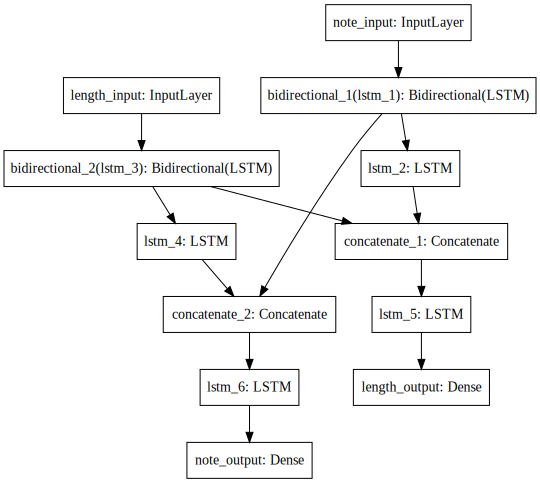

In [9]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.6
	epochs_drop = 25
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [11]:
def listen_callback(epoch, logs):
    if epoch % 1 == 0 and epoch > -1: 
    # if epoch < -2:
        print('----- Generating melody after Epoch: %d' % epoch)
        
        start_index = random.randint(0, 7000)
        for diversity in [0.5]:
            print('----- diversity:', diversity)

            current_note_phrase = notes_corpus[start_index: start_index + n_time_steps]
            current_length_phrase = length_corpus[start_index: start_index + n_time_steps]

            phrases = {'note_phrase': current_note_phrase, 'length_phrase': current_length_phrase}

            generated_notes = []
            generated_lengths = []
            generated_notes.extend(current_note_phrase)
            generated_lengths.extend(current_length_phrase)

            # model, phrases,categorized_variables, lookup_indicies, n_time_steps, diversity, n_to_generate
            for step in range(70):
                encoded_prediction = make_encoded_prediction(
                    model=model,
                    phrases=phrases,
                    categorized_variables=categorized_variables,
                    lookup_indicies=lookup_indicies,
                    n_time_steps=n_time_steps
                )

                predictions = decode_predictions(
                    encoded_prediction=encoded_prediction,
                    lookup_indicies=lookup_indicies,
                    temperature=diversity
                )

                generated_notes.append(predictions['note_prediction']) 
                generated_lengths.append(predictions['length_prediction']) 

                phrases['note_phrase'] = np.append(phrases['note_phrase'][1:], predictions['note_prediction'])
                phrases['length_phrase'] = np.append(phrases['length_phrase'][1:], predictions['length_prediction'])

            play_generated_phrase(
                generated_notes=generated_notes[10:],
                generated_lengths=generated_lengths[10:],
                player=player)

In [12]:
lrate = LearningRateScheduler(step_decay)

In [13]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(datetime.datetime.now()), histogram_freq=0, write_graph=True)

In [14]:
listen_callback = LambdaCallback(on_epoch_end=listen_callback)

In [15]:
logger('TRAINING')
model.fit([note_x, length_x], [note_y, length_y],
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[
              listen_callback,
              tensorboard,
            ]
          )

          **********************************
            TRAINING
          **********************************
Epoch 1/500
4096/4272 [===========================>..] - ETA: 0s - loss: 5.2698 - note_output_loss: 3.4833 - length_output_loss: 3.5730----- Generating melody after Epoch: 0
----- diversity: 0.5
56 | 0.42
0 | 0.37
0 | 0.46
62 | 1.7
0 | 0.46
0 | 0.33
0 | 0.14
0 | 0.42
65 | 0.42
0 | 0.46
0 | 0.37
65 | 0.56
60 | 0.28
0 | 1.3
0 | 0.42
0 | 0.51
0 | 0.28
0 | 0.56
0 | 0.37
0 | 0.33
57 | 0.42
0 | 0.09
60 | 0.65
0 | 0.37
61 | 0.28
0 | 0.37
0 | 0.98
54 | 0.56
52 | 0.33
56 | 0.33
0 | 0.46
0 | 0.28
0 | 0.42
0 | 0.42
0 | 0.42
53 | 0.33
0 | 0.46
58 | 0.74
58 | 0.42
0 | 0.37
0 | 0.42
0 | 0.42
65 | 0.65
0 | 0.19
0 | 0.37
0 | 0.42
0 | 0.28
0 | 0.65
0 | 0.56
0 | 0.05
0 | 0.84
0 | 0.37
0 | 0.33
0 | 0.7
0 | 0.33
0 | 0.46
0 | 0.33
0 | 0.23
0 | 0.42
0 | 0.37
4272/4272 [==============================] - 47s 11ms/step - loss: 5.2384 - note_output_loss: 3.4596 - length_output_loss: 3.5577
Epoch 2/500


64 | 0.33
66 | 0.37
72 | 0.6
0 | 0.84
65 | 0.33
60 | 0.65
70 | 0.28
66 | 0.37
65 | 0.42
0 | 0.33
0 | 0.56
61 | 0.51
73 | 0.14
64 | 0.7
65 | 0.37
70 | 0.42
0 | 0.74
0 | 0.37
68 | 0.28
65 | 0.32
70 | 0.6
0 | 0.42
0 | 0.51
0 | 0.33
0 | 1.4
0 | 2.9
0 | 0.33
0 | 0.46
0 | 0.33
67 | 0.23
63 | 2.7
0 | 0.33
0 | 1.6
0 | 0.64
0 | 0.7
64 | 0.42
67 | 0.6
0 | 0.42
62 | 0.42
0 | 0.65
0 | 0.28
0 | 1.5
65 | 0.0
0 | 1.6
74 | 0.39
61 | 0.42
0 | 0.28
68 | 0.33
61 | 1.4
0 | 1.5
0 | 0.03
65 | 1.9
48 | 1.7
81 | 0.55
65 | 0.23
48 | 0.79
65 | 0.33
65 | 0.28
72 | 0.6
63 | 0.46
4272/4272 [==============================] - 57s 13ms/step - loss: 4.0138 - note_output_loss: 2.5276 - length_output_loss: 2.9723
Epoch 10/500
4096/4272 [===========================>..] - ETA: 0s - loss: 3.9736 - note_output_loss: 2.4999 - length_output_loss: 2.9475----- Generating melody after Epoch: 9
----- diversity: 0.5
0 | 1.3
62.0 | 0.51
67.0 | 0.51
69.0 | 0.93
0 | 0.84
59.0 | 0.46
64.0 | 0.56
65.0 | 0.42
66.0 | 0.56
0 | 0.7
60 | 0.

77 | 0.93
78 | 0.91
43 | 1.4
0 | 0.64
64 | 2.5
0 | 0.05
0 | 0.51
0 | 0.28
0 | 0.65
0 | 0.28
0 | 0.37
0 | 0.14
0 | 0.42
0 | 0.42
0 | 0.19
0 | 1.0
0 | 0.09
67 | 1.2
61 | 0.7
0 | 0.14
62 | 1.4
79 | 0.96
80 | 1.4
0 | 0.68
61 | 0.33
63 | 0.56
59 | 0.05
72 | 0.65
47 | 1.6
61 | 0.72
47 | 0.46
0 | 0.46
0 | 0.05
0 | 0.6
0 | 0.19
4272/4272 [==============================] - 69s 16ms/step - loss: 3.5658 - note_output_loss: 2.1884 - length_output_loss: 2.7547
Epoch 18/500
4096/4272 [===========================>..] - ETA: 0s - loss: 3.4832 - note_output_loss: 2.1285 - length_output_loss: 2.7094----- Generating melody after Epoch: 17
----- diversity: 0.5
62.0 | 0.28
0 | 0.88
50.0 | 0.46
53.0 | 0.51
55.0 | 1.0
0 | 0.74
56.0 | 0.6
73.0 | 0.46
62.0 | 0.09
63.0 | 1.1
66 | 0.56
68 | 0.51
68 | 1.2
0 | 0.65
62 | 0.51
68 | 0.56
0 | 0.65
64 | 0.56
65 | 0.46
70 | 0.51
68 | 0.65
68 | 0.46
70 | 0.56
68 | 0.65
68 | 0.51
68 | 0.65
0 | 0.46
63 | 0.51
66 | 1.2
68 | 0.51
66 | 0.84
66 | 0.84
68 | 0.65
0 | 0.7
62 | 0.

46 | 1.5
31 | 0.44
57 | 0.89
38 | 0.06
0 | 4.7
46 | 0.76
0 | 4.9
4272/4272 [==============================] - 89s 21ms/step - loss: 3.1638 - note_output_loss: 1.8940 - length_output_loss: 2.5395
Epoch 26/500
4096/4272 [===========================>..] - ETA: 0s - loss: 3.1495 - note_output_loss: 1.8868 - length_output_loss: 2.5253----- Generating melody after Epoch: 25
----- diversity: 0.5
56.0 | 0.42
59.0 | 0.33
58.0 | 0.46
59.0 | 0.14
0 | 1.3
50.0 | 0.37
52.0 | 0.37
55.0 | 0.84
0 | 1.5
50.0 | 0.37
54 | 0.42
56 | 0.14
58 | 1.5
0 | 0.84
53 | 0.37
51 | 0.37
55 | 0.65
0 | 0.65
54 | 0.37
55 | 0.42
58 | 0.33
59 | 0.84
0 | 0.42
60 | 0.37
62 | 0.37
63 | 1.3
0 | 0.42
54 | 0.42
58 | 0.42
59 | 0.42
56 | 0.88
0 | 0.46
48 | 0.42
53 | 0.42
55 | 0.42
57 | 1.3
0 | 0.19
54 | 0.37
56 | 0.51
58 | 0.74
0 | 1.1
53 | 0.37
55 | 0.37
0 | 0.46
58 | 0.37
60 | 0.37
64 | 0.51
0 | 0.42
55 | 0.42
56 | 0.37
57 | 0.56
59 | 0.6
0 | 0.28
54 | 0.42
56 | 0.51
0 | 0.56
53 | 0.37
55 | 0.42
58 | 0.42
0 | 0.42
51 | 0.37
54 

KeyboardInterrupt: 

In [ ]:
save_model(model, 'model_2')